In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 21.6 MB/s eta 0:00:00


In [2]:
import optuna
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import STL10
from torch.utils.data import random_split, Subset
from torchvision.models import resnet18
import matplotlib.pyplot as plt

In [3]:
# 기본 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 10
EPOCHS = 20

In [4]:
# STL-10 is a set of 13k images 96x96 pixels on 3 channels
IMG_CHANNELS = 3
IMG_ROWS = 96
IMG_COLS = 96

In [6]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.RandomCrop(96, padding=4),
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=transform)

dataset_aug = STL10(root='./data', split='train', download=True, transform=aug_transform)
dataset_clean = STL10(root='./data', split='train', download=True, transform=transform)

train_size = int(0.8 * len(dataset_aug))
val_size = len(dataset_aug) - train_size
train_indices, val_indices = random_split(range(len(dataset_aug)), [train_size, val_size])

train_dataset = Subset(dataset_aug, train_indices)
val_dataset = Subset(dataset_clean, val_indices)

In [9]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    wd = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model = model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(EPOCHS):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        history['train_loss'].append(running_loss / len(train_loader))
        history['train_acc'].append(correct / total)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_correct / val_total)

    trial.set_user_attr("history", history)
    return history['val_acc'][-1]  # 마지막 epoch 기준

In [10]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

print("✅ Best Trial:", study.best_trial.params)
print("✅ Best Accuracy:", study.best_value)

[I 2025-07-13 14:26:55,011] A new study created in memory with name: no-name-6d327f38-d1f2-4455-8a38-f73e4e562198
[I 2025-07-13 14:30:27,739] Trial 0 finished with value: 0.801 and parameters: {'lr': 0.0005271610211298979, 'weight_decay': 0.000848072341173791, 'batch_size': 32}. Best is trial 0 with value: 0.801.
[I 2025-07-13 14:34:00,433] Trial 1 finished with value: 0.85 and parameters: {'lr': 0.00014992539472173243, 'weight_decay': 0.00038082207697351676, 'batch_size': 32}. Best is trial 1 with value: 0.85.
[I 2025-07-13 14:37:19,295] Trial 2 finished with value: 0.678 and parameters: {'lr': 0.0029402883510599525, 'weight_decay': 1.0140223476464352e-05, 'batch_size': 64}. Best is trial 1 with value: 0.85.
[I 2025-07-13 14:40:38,779] Trial 3 finished with value: 0.408 and parameters: {'lr': 0.008230226913411031, 'weight_decay': 2.2158441157346267e-05, 'batch_size': 64}. Best is trial 1 with value: 0.85.
[I 2025-07-13 14:43:58,186] Trial 4 finished with value: 0.71 and parameters: {'

✅ Best Trial: {'lr': 0.00014992539472173243, 'weight_decay': 0.00038082207697351676, 'batch_size': 32}
✅ Best Accuracy: 0.85


In [11]:
best_params = study.best_trial.params
lr = best_params["lr"]
wd = best_params["weight_decay"]
batch_size = best_params["batch_size"]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(EPOCHS):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100. * correct / total

print(f"\nTest loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.2f}%")


Test loss: 0.5388
Test accuracy: 85.21%


In [13]:
torch.save(model.state_dict(), 'best_model.pth')

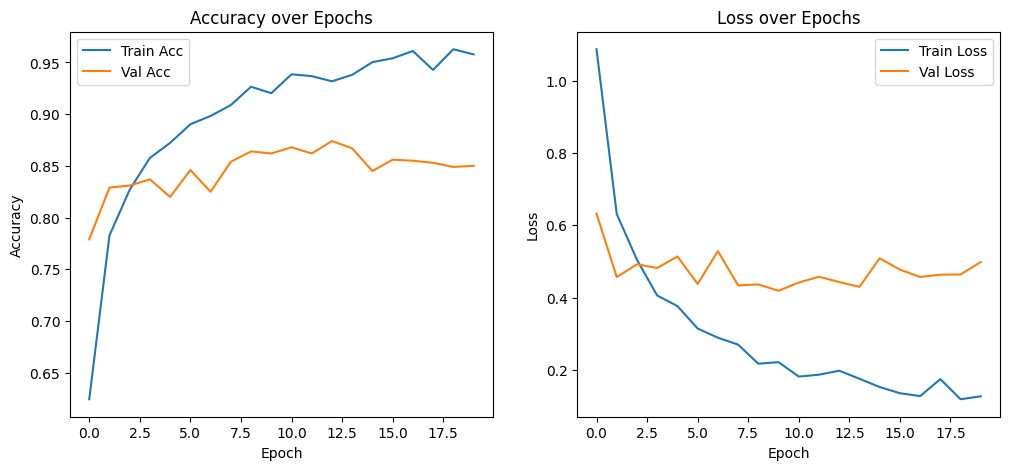

In [12]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(study.best_trial.user_attrs['history'])